In [1]:
!pip install torch
!pip install pandas
!pip install nltk
!pip install emoji

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [6]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import Trainer, TrainingArguments
import pandas as pd
import re
import emoji
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import torch.nn as nn
from sklearn.model_selection import train_test_split
#import accelerate
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
# Splitting the dataset
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_dataset = CommentDataset(train_df['sequences'].tolist(), train_df['mapped_labels'].tolist())
test_dataset = CommentDataset(test_df['sequences'].tolist(), test_df['mapped_labels'].tolist())

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)


NameError: name 'CommentDataset' is not defined

In [8]:

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load data
df = pd.read_csv('/thelinkof/cleaned_movie_data_comment.csv')

# Data cleaning function
def clean_text(text):
    text = re.sub(r'<.*?>', '', str(text))
    text = emoji.replace_emoji(text, replace='')
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.lower().strip()
    return text

df['cleaned_comment'] = df['comment_text'].apply(clean_text)

# Tokenization and Stop-Word Removal
stop_words = set(stopwords.words('turkish'))
def tokenize_and_remove_stop_words(text):
    tokens = word_tokenize(text, language='turkish')
    tokens = [token for token in tokens if token not in stop_words and len(token) > 1]
    return tokens

df['tokens'] = df['cleaned_comment'].apply(tokenize_and_remove_stop_words)

# Convert tokens to sequences
def tokens_to_sequence(tokens, vocab, max_len):
    sequence = [vocab.get(token, 1) for token in tokens]  # 1 is the index for unknown words
    if len(sequence) < max_len:
        sequence += [0] * (max_len - len(sequence))  # Padding
    return sequence[:max_len]

# Building vocabulary from tokens
all_tokens = [token for sublist in df['tokens'].tolist() for token in sublist]
vocab = {token: idx + 2 for idx, token in enumerate(set(all_tokens))}
vocab['<PAD>'] = 0  # Padding
vocab['<UNK>'] = 1  # Unknown words

# Convert all tokens to sequences
max_len = 512
df['sequences'] = df['tokens'].apply(lambda x: tokens_to_sequence(x, vocab, max_len))

# Remap the ratings to 0, 1, 2
df['mapped_labels'] = df['comment_rating'].apply(lambda x: 2 if x >= 7 else (1 if x >= 4 else 0))
print("Unique labels after mapping:", df['mapped_labels'].unique())

# Creating the dataset
class CommentDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        sequence = torch.tensor(self.sequences[index], dtype=torch.long)
        label = torch.tensor(self.labels[index], dtype=torch.long)
        return sequence, label

# Splitting the dataset
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_dataset = CommentDataset(train_df['sequences'].tolist(), train_df['mapped_labels'].tolist())
test_dataset = CommentDataset(test_df['sequences'].tolist(), test_df['mapped_labels'].tolist())

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Define the RNN model
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers):
        super(SentimentRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        out = self.dropout(lstm_out[:, -1, :])  # Take the output of the last timestep
        return self.linear(out)

# Initialize the model
output_size = 3  # Assuming 3 classes
embedding_dim = 400
hidden_dim = 256
n_layers = 2
vocab_size = len(vocab)  # Number of unique tokens in vocab
model = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers).to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=16,  # batch size for training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch"
)

# Define Trainer
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        # Define how to compute loss in custom Trainer
        inputs, labels = inputs['input_ids'], inputs['labels']
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        return (loss, outputs) if return_outputs else loss

train_features = [{'input_ids': inputs, 'labels': labels} for inputs, labels in train_loader]
eval_features = [{'input_ids': inputs, 'labels': labels} for inputs, labels in test_loader]

trainer = CustomTrainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_features,        # training dataset
    eval_dataset=eval_features           # evaluation dataset
)

# Train and evaluate the model
trainer.train()
eval_result = trainer.evaluate()
print(f"Results: {eval_result}")

Using device: cuda
Unique labels after mapping: [2 1 0]


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.21.0`: Please run `pip install transformers[torch]` or `pip install accelerate -U`

In [9]:
import pandas as pd
import re
import emoji
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

# Load data
df = pd.read_csv('/thelinkof/cleaned_movie_data_comment.csv')

# Clean text data
def clean_text(text):
    if not isinstance(text, str):
        return ''
    text = re.sub(r'<.*?>', '', text)
    text = emoji.replace_emoji(text, replace='')
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', '', text)
    text = text.lower().strip()
    return text

df['cleaned_comment'] = df['comment_text'].apply(clean_text)

# Tokenize using RNN-based tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['cleaned_comment'])

sequences = tokenizer.texts_to_sequences(df['cleaned_comment'])
padded_sequences = pad_sequences(sequences, maxlen=512)

# One-hot encode labels
labels = df['comment_rating'].apply(lambda x: 2 if x >= 7 else (1 if x >= 4 else 0))
labels = to_categorical(labels)

# Split data
train_sequences, test_sequences, train_labels, test_labels = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Define RNN model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=512))
model.add(LSTM(units=64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
model.fit(train_sequences, train_labels, epochs=3, batch_size=16, validation_data=(test_sequences, test_labels))

# Evaluate model
loss, accuracy = model.evaluate(test_sequences, test_labels)
print(f"Results: Loss={loss:.3f}, Accuracy={accuracy:.3f}")

Epoch 1/3
1182/1182 [==============================] - 2020s 2s/step - loss: 0.4057 - accuracy: 0.8897 - val_loss: 0.4390 - val_accuracy: 0.8749
Epoch 2/3
1182/1182 [==============================] - 1943s 2s/step - loss: 0.3363 - accuracy: 0.9110 - val_loss: 0.4631 - val_accuracy: 0.8665
Epoch 3/3
148/148 [==============================] - 20s 132ms/step - loss: 0.4725 - accuracy: 0.8451
Results: Loss=0.472, Accuracy=0.845


In [ ]:
#total one:




!pip install torch pandas nltk emoji transformers

import torch
import pandas as pd
import re
import emoji
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from torch.utils.data import DataLoader, Dataset
from transformers import Trainer, TrainingArguments
import torch.nn as nn
from sklearn.model_selection import train_test_split
import nltk
nltk.download('punkt')
nltk.download('stopwords')

# Load data
df = pd.read_csv('/thelinkof/cleaned_movie_data_comment.csv')

# Data cleaning function
def clean_text(text):
    text = re.sub(r'<.*?>', '', str(text))
    text = emoji.replace_emoji(text, replace='')
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.lower().strip()
    return text

df['cleaned_comment'] = df['comment_text'].apply(clean_text)

# Tokenization and Stop-Word Removal
stop_words = set(stopwords.words('turkish'))
def tokenize_and_remove_stop_words(text):
    tokens = word_tokenize(text, language='turkish')
    tokens = [token for token in tokens if token not in stop_words and len(token) > 1]
    return tokens

df['tokens'] = df['cleaned_comment'].apply(tokenize_and_remove_stop_words)

# Convert tokens to sequences
def tokens_to_sequence(tokens, vocab, max_len):
    sequence = [vocab.get(token, 1) for token in tokens]  # 1 is the index for unknown words
    if len(sequence) < max_len:
        sequence += [0] * (max_len - len(sequence))  # Padding
    return sequence[:max_len]

# Building vocabulary from tokens
all_tokens = [token for sublist in df['tokens'].tolist() for token in sublist]
vocab = {token: idx + 2 for idx, token in enumerate(set(all_tokens))}
vocab['<PAD>'] = 0  # Padding
vocab['<UNK>'] = 1  # Unknown words

# Convert all tokens to sequences
max_len = 512
df['sequences'] = df['tokens'].apply(lambda x: tokens_to_sequence(x, vocab, max_len))

# Remap the ratings to 0, 1, 2
df['mapped_labels'] = df['comment_rating'].apply(lambda x: 2 if x >= 7 else (1 if x >= 4 else 0))
print("Unique labels after mapping:", df['mapped_labels'].unique())

# Creating the dataset
class CommentDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        sequence = torch.tensor(self.sequences[index], dtype=torch.long)
        label = torch.tensor(self.labels[index], dtype=torch.long)
        return sequence, label

# Splitting the dataset
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_dataset = CommentDataset(train_df['sequences'].tolist(), train_df['mapped_labels'].tolist())
test_dataset = CommentDataset(test_df['sequences'].tolist(), test_df['mapped_labels'].tolist())

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Define the RNN model
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers):
        super(SentimentRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        out = self.dropout(lstm_out[:, -1, :])  # Take the output of the last timestep
        return self.linear(out)

# Initialize the model
output_size = 3  # Assuming 3 classes
embedding_dim = 400
hidden_dim = 256
n_layers = 2
vocab_size = len(vocab)  # Number of unique tokens in vocab
model = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers).to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=16,  # batch size for training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch"
)

# Define Trainer
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        # Define how to compute loss in custom Trainer
        inputs, labels = inputs['input_ids'], inputs['labels']
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        return (loss, outputs) if return_outputs else loss

train_features = [{'input_ids': inputs, 'labels': labels} for inputs, labels in train_loader]
eval_features = [{'input_ids': inputs, 'labels': labels} for inputs, labels in test_loader]

trainer = CustomTrainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_features,        # training dataset
    eval_dataset=eval_features           # evaluation dataset
)

# Train and evaluate the model
trainer.train()
eval_result = trainer.evaluate()
print(f"Results: {eval_result}")


148/148 [==============================] - 21s 142ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


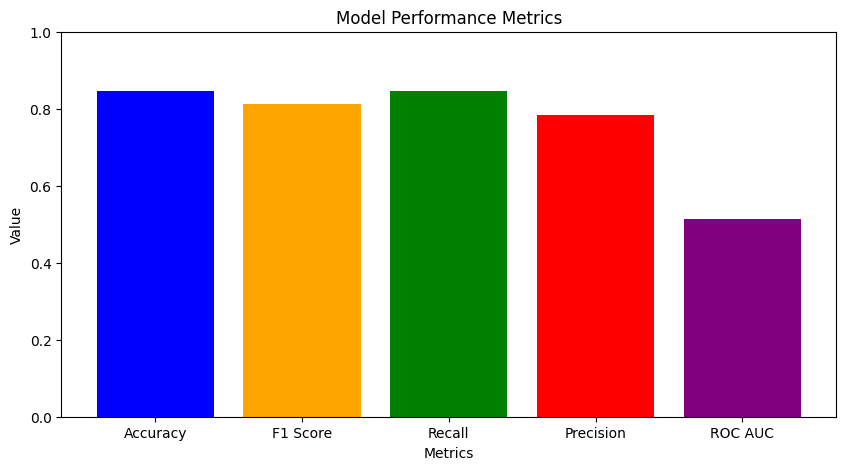

In [10]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score
import matplotlib.pyplot as plt

# Evaluate function
def evaluate(model, test_sequences, test_labels):
    predictions = model.predict(test_sequences)
    predictions = predictions.argmax(axis=1)
    true_labels = test_labels.argmax(axis=1)

    return predictions, true_labels

# Evaluate the model
predictions, true_labels = evaluate(model, test_sequences, test_labels)

# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
precision = precision_score(true_labels, predictions, average='weighted')
roc_auc = roc_auc_score(pd.get_dummies(true_labels), pd.get_dummies(predictions), multi_class='ovr')

# Plot metrics
metrics = {'Accuracy': accuracy, 'F1 Score': f1, 'Recall': recall, 'Precision': precision, 'ROC AUC': roc_auc}
metrics_names = list(metrics.keys())
metrics_values = list(metrics.values())
plt.figure(figsize=(10, 5))
plt.bar(metrics_names, metrics_values, color=['blue', 'orange', 'green', 'red', 'purple'])
plt.xlabel('Metrics')
plt.ylabel('Value')
plt.title('Model Performance Metrics')
plt.ylim(0, 1)
plt.show()



In [11]:
for metric_name, metric_value in metrics.items():
    print(f"{metric_name}: {metric_value:.4f}")

Accuracy: 0.8451
F1 Score: 0.8113
Recall: 0.8451
Precision: 0.7832
ROC AUC: 0.5126
